# Group Project: Grin

# Setup

In [1]:
import requests
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import folium
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv

In [2]:
# Use double quotes to assign your API key to private_api_key variable as a string
# .env to prevent this
# Load environment variables from .env file
load_dotenv(dotenv_path="./data/.env")

# Access the private API key
private_api_key = os.getenv("METEOSTAT_PRIVATE_KEY")

# Access API data

In [3]:
# Access the API keys
meteostat_api_key = os.getenv("METEOSTAT_PRIVATE_KEY")
foursquare_api_key = os.getenv("FOUR_SQUARE_API_KEY")

In [4]:
# Function to query weather data for a specific city from weather api
def get_weather_data(city_name, lat, lon, alt=43, start='2023-10-21', end='2024-10-21'):
    weather_api_url = "https://meteostat.p.rapidapi.com/point/daily"
    weather_headers = {
    'x-rapidapi-host': "meteostat.p.rapidapi.com",
    'x-rapidapi-key': meteostat_api_key
}

    params = {
        'lat': lat,
        'lon': lon,
        'alt': alt,
        'start': start,
        'end': end
    }
    
    response = requests.get(weather_api_url, headers=weather_headers, params=params)

    # Test response
    if response.status_code == 200:
        weather_data = response.json()
        weather_df = pd.DataFrame(weather_data['data'])
        weather_df['date'] = pd.to_datetime(weather_df['date'])
        return weather_df
    else:
        print(f"Failed to retrieve weather data for {city_name}. Status code: {response.status_code}")
        return None

In [5]:
# Function to query places data for a specific city from places api
def get_places_data(city_name, lat, lon, radius=1000):
    places_url = f"https://api.foursquare.com/v3/places/search?ll={lat},{lon}&radius={radius}"
    headers = {'Authorization': foursquare_api_key}
    response = requests.get(places_url, headers=headers)
    
    if response.status_code == 200:
        places_data = response.json()
        foursquare_data = []
        for place in places_data['results']:
            foursquare_data.append({
                'fsq_id': place['fsq_id'],
                'name': place['name'],
                'category': place['categories'][0]['name'],
                'latitude': place['geocodes']['main']['latitude'],
                'longitude': place['geocodes']['main']['longitude'],
                'address': place['location'].get('address', 'No address available'),
                'locality': place['location'].get('locality', 'Unknown locality')
            })
        return pd.DataFrame(foursquare_data)
    else:
        print(f"Failed to retrieve places data for {city_name}. Status code: {response.status_code}")
        return None

# Simulate entire year's bike traffic in Berlin, Frankfurt and Munich

In [6]:
# Function to generate random points for the simulation
def generate_random_points(n_points, vehicle_type, lat_min, lat_max, lon_min, lon_max):
    data = {
        'latitude': np.random.uniform(lat_min, lat_max, n_points),
        'longitude': np.random.uniform(lon_min, lon_max, n_points),
        'vehicle_type': [vehicle_type] * n_points
    }
    df = pd.DataFrame(data)
    
    # Introduce some missing values to simulate real-world data
    missing_indices = random.sample(range(n_points), int(n_points * 0.1))  # 10% missing values
    df.loc[missing_indices, 'vehicle_type'] = np.nan  # Missing vehicle type
    df.loc[missing_indices[:int(len(missing_indices)/2)], 'latitude'] = np.nan  # Missing latitude
    
    return df

In [7]:
# Function to find the nearest place for a given vehicle point using foursquare api
def find_nearest_place(vehicle_lat, vehicle_lon, places_df):
    min_distance = float('inf')
    nearest_place = None
    
    for idx, place in places_df.iterrows():
        place_coords = (place['latitude'], place['longitude'])
        vehicle_coords = (vehicle_lat, vehicle_lon)
        
        # Calculate distance
        distance = geodesic(vehicle_coords, place_coords).meters
        
        if distance < min_distance:
            min_distance = distance
            nearest_place = place
            
    return nearest_place, min_distance

In [8]:
# Function to run simulation
def run_simulation(n_batches, batch_size, vehicle_type, city_name, weather_df, places_df, lat_min, lat_max, lon_min, lon_max):
    all_batches_data = []

    for batch_num in range(n_batches):
        # Generate random points for the current batch within the city's coordinate range
        vehicle_df = generate_random_points(batch_size, vehicle_type, lat_min, lat_max, lon_min, lon_max)
        
        # Shuffle the data to introduce randomness
        vehicle_df = vehicle_df.sample(frac=1).reset_index(drop=True)
        
        # Fill missing data
        vehicle_df['vehicle_type'] = vehicle_df['vehicle_type'].fillna('unknown')
        vehicle_df['latitude'] = vehicle_df['latitude'].fillna(vehicle_df['latitude'].median())
        vehicle_df['longitude'] = vehicle_df['longitude'].fillna(vehicle_df['longitude'].median())
        
        # Assign nearest places
        vehicle_places_data = []
        for idx, vehicle in vehicle_df.iterrows():
            nearest_place, distance = find_nearest_place(vehicle['latitude'], vehicle['longitude'], places_df)
            vehicle_places_data.append({
                'city': city_name,
                'latitude': vehicle['latitude'],
                'longitude': vehicle['longitude'],
                'vehicle_type': vehicle['vehicle_type'],
                'nearest_place_name': nearest_place['name'] if nearest_place is not None else 'None',
                'place_category': nearest_place['category'] if nearest_place is not None else 'None',
                'distance_to_place': distance if nearest_place is not None else 'N/A'
            })
        
        vehicle_places_df = pd.DataFrame(vehicle_places_data)
        
        # Assign the corresponding weather condition and date to each batch
        if batch_num < len(weather_df):
            weather_row = weather_df.iloc[batch_num]
            vehicle_places_df['weather_date'] = weather_row['date']
            vehicle_places_df['temperature'] = weather_row['tavg']
            vehicle_places_df['precipitation'] = weather_row['prcp']
            vehicle_places_df['wind_speed'] = weather_row['wspd']
        else:
            vehicle_places_df['weather_date'] = None
            vehicle_places_df['temperature'] = None
            vehicle_places_df['precipitation'] = None
            vehicle_places_df['wind_speed'] = None
        
        # Append the batch data to the list
        all_batches_data.append(vehicle_places_df)

    # Concatenate all batch results into a single DataFrame
    final_data = pd.concat(all_batches_data, ignore_index=True)

    return final_data

In [9]:
# Run the simulation for each city
def run_simulation_for_cities():
    cities = {
        'Berlin': {'lat': 52.5244, 'lon': 13.4105, 'lat_min': 52.50, 'lat_max': 52.55, 'lon_min': 13.35, 'lon_max': 13.45},
        'Frankfurt': {'lat': 50.1109, 'lon': 8.6821, 'lat_min': 50.10, 'lat_max': 50.12, 'lon_min': 8.66, 'lon_max': 8.70},
        'Munich': {'lat': 48.1351, 'lon': 11.5820, 'lat_min': 48.12, 'lat_max': 48.15, 'lon_min': 11.55, 'lon_max': 11.60}
    }
    
    all_city_data = []
    
    for city_name, city_info in cities.items():
        print(f"Running simulation for {city_name}...")
        
        # Get weather and places data for the city
        weather_df = get_weather_data(city_name, city_info['lat'], city_info['lon'])
        places_df = get_places_data(city_name, city_info['lat'], city_info['lon'])
        
        # Run the simulation for the city with batch size of 10 and 366 batches
        city_data = run_simulation(
            n_batches=366, 
            batch_size=10, 
            vehicle_type='bike', 
            city_name=city_name, 
            weather_df=weather_df, 
            places_df=places_df,
            lat_min=city_info['lat_min'], 
            lat_max=city_info['lat_max'], 
            lon_min=city_info['lon_min'], 
            lon_max=city_info['lon_max']
        )
        
        all_city_data.append(city_data)
    
    # Combine all cities' data into one DataFrame
    final_data = pd.concat(all_city_data, ignore_index=True)
    
    # Save the final DataFrame to a CSV file
    final_data.to_csv('./data/final_vehicle_places_weather_data_all_cities.csv', index=False)
    
    return final_data

In [10]:
# Run the simulation for all cities and get the final combined data
final_vehicle_places_weather_data = run_simulation_for_cities()


Running simulation for Berlin...
Running simulation for Frankfurt...
Running simulation for Munich...


# Further Data Wrangling

In [11]:
# Further wrangling

bike_sim = pd.read_csv('./data/final_vehicle_places_weather_data_all_cities.csv')

# Regroup place_category
bike_sim['place_category'] = bike_sim['place_category'].replace({
    r'.*(Restaurant|Joint|Bistro|Steakhouse).*': 'Restaurant',
    r'.*Bar.*': 'Bar',
    r'.*(Café|Coffee Shop).*': 'Cafe and Tea House'
}, regex=True)

# Convert the 'weather_date' column to datetime format
bike_sim['weather_date'] = pd.to_datetime(bike_sim['weather_date'])

# Create a new column 'business_quarter'
bike_sim['business_quarter'] = 'Q' + bike_sim['weather_date'].dt.quarter.astype(str)

# Save the modified DataFrame to a new CSV file if needed
bike_sim.to_csv('./data/final_data_augmented.csv', index=False)

bike_sim.head()

,city,latitude,longitude,vehicle_type,nearest_place_name,place_category,distance_to_place,weather_date,temperature,precipitation,wind_speed,business_quarter
0,Berlin,52.519843,13.351534,bike,The Klub Kitchen,Restaurant,3705.537131,2023-10-21,11.0,1.7,12.5,Q4
1,Berlin,52.544050,13.406694,bike,The Klub Kitchen,Restaurant,1815.516254,2023-10-21,11.0,1.7,12.5,Q4
2,Berlin,52.523288,13.419090,bike,Neue Babylon Berlin GmbH,Indie Movie Theater,594.969592,2023-10-21,11.0,1.7,12.5,Q4
3,Berlin,52.525182,13.414059,unknown,Neue Babylon Berlin GmbH,Indie Movie Theater,194.894109,2023-10-21,11.0,1.7,12.5,Q4
4,Berlin,52.515332,13.422828,bike,Mama Vân - Sài Gòn Deli,Restaurant,1215.762658,2023-10-21,11.0,1.7,12.5,Q4


# Plots

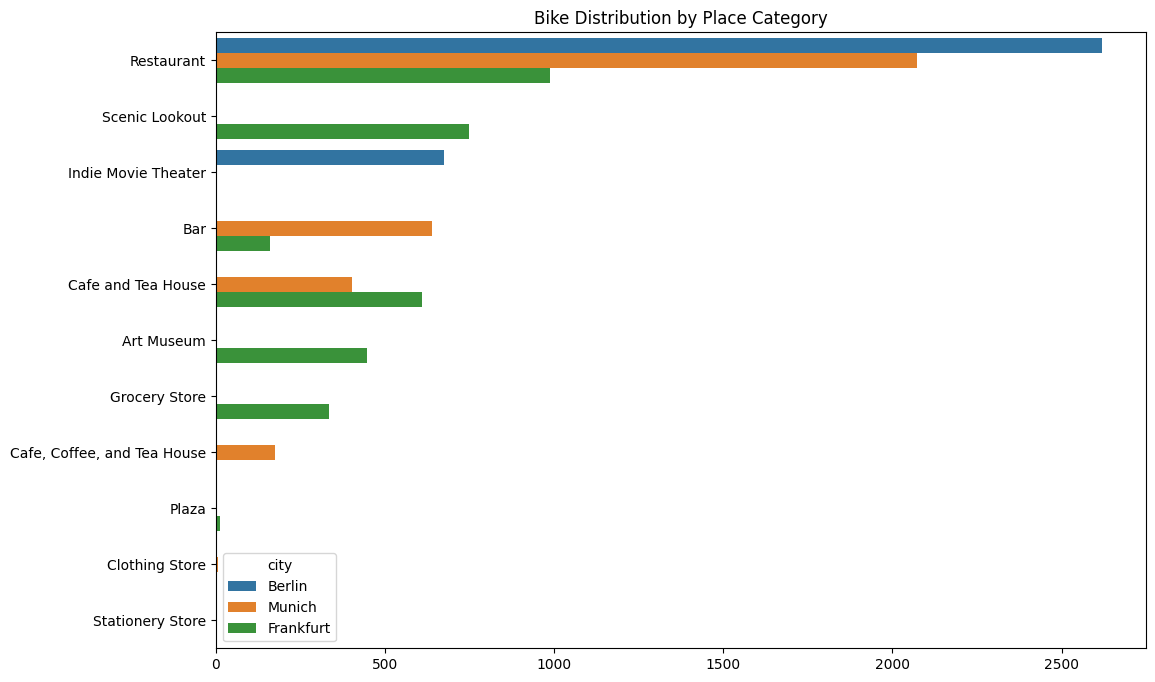

In [12]:
# Load the data
viz_sim = pd.read_csv('./data/final_data_augmented.csv')

# Clean the data by ignoring rows with unknown vehicle type
bike_sim_clean = viz_sim[viz_sim['vehicle_type'] != 'unknown']

# Group by place category and city, bike counts
place_city_bike = bike_sim_clean.groupby(['place_category', 'city']).agg(
    bike_count=('vehicle_type', 'count')
).reset_index()

# Plot 1: Bike distribution by place category and city
plt.figure(figsize=(12, 8))
sns.barplot(data=place_city_bike.sort_values(by='bike_count', ascending=False), 
            x='bike_count', y='place_category', hue='city')
plt.title('Bike Distribution by Place Category')
plt.xlabel('')
plt.ylabel('')
plt.show()

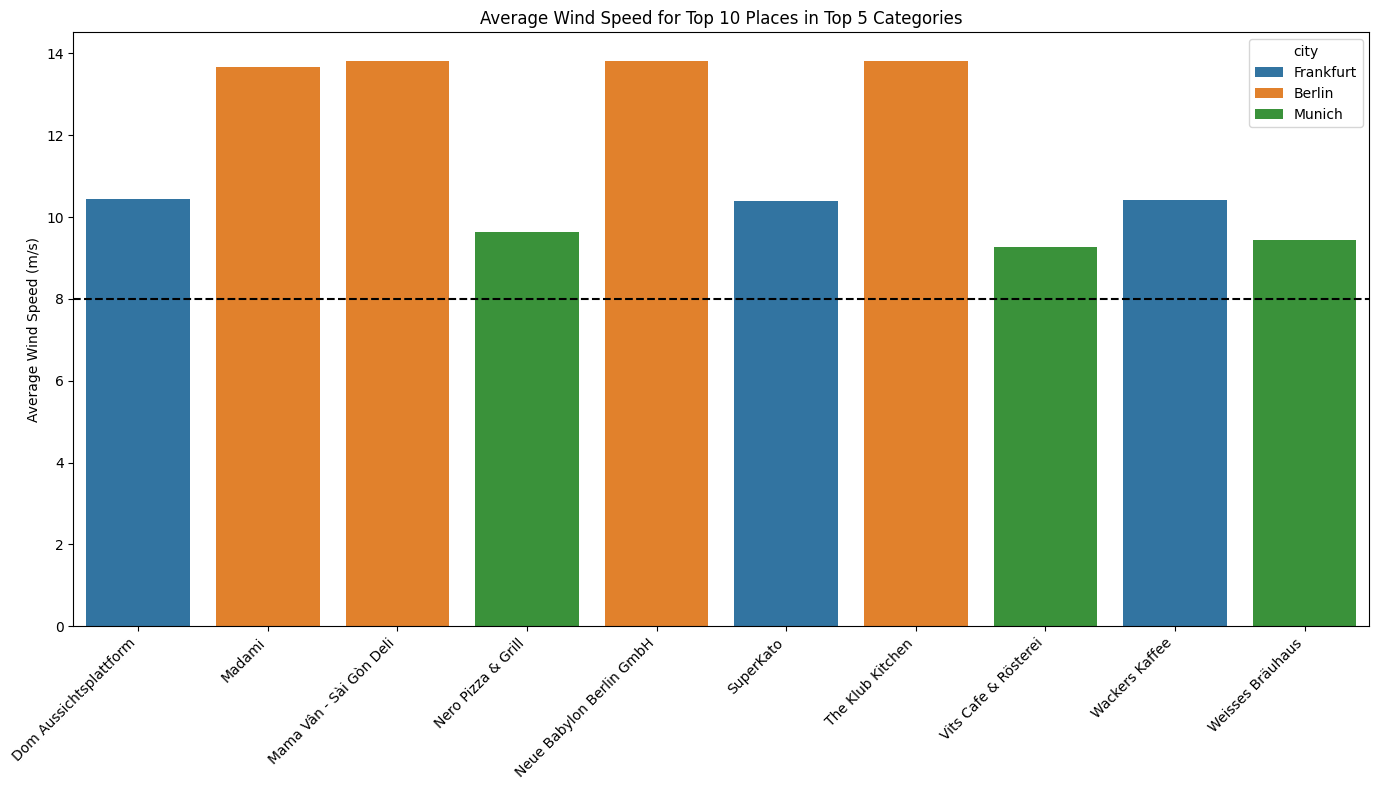

In [13]:
# Identify the top 5 place categories by bike counts
top_categories = place_city_bike.groupby('place_category')['bike_count'].sum().nlargest(5).index

# Filter the data for the top categories and bike counts per nearest place name
top_places = bike_sim_clean[bike_sim_clean['place_category'].isin(top_categories)]

# Count bikes per nearest place name
top_places_counts = top_places.groupby(['nearest_place_name', 'place_category', 'city']).agg(
    bike_count=('vehicle_type', 'count')
).reset_index()

# Get the top 10 places across all top categories
top_places_top10 = top_places_counts.nlargest(10, 'bike_count') 

# Calculate average wind speed and precipitation for these selected places
avg_wind_precip = bike_sim_clean[bike_sim_clean['nearest_place_name'].isin(top_places_top10['nearest_place_name'])].groupby('nearest_place_name').agg(
    avg_wind_speed=('wind_speed', 'mean'),
    avg_precipitation=('precipitation', 'mean'),
    city=('city', 'first')  # Keep city for coloring
).reset_index()

# Set thresholds: 8 m/s for wind speed and 5 mm for precipitation
wind_speed_threshold = 8
precipitation_threshold = 5

# Plot Average Wind Speed for top places
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_wind_precip, x='nearest_place_name', y='avg_wind_speed', hue='city')
plt.axhline(y=wind_speed_threshold, color='black', linestyle='--')
plt.title('Average Wind Speed for Top 10 Places in Top 5 Categories')
plt.xlabel('')
plt.ylabel('Average Wind Speed (m/s)')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()


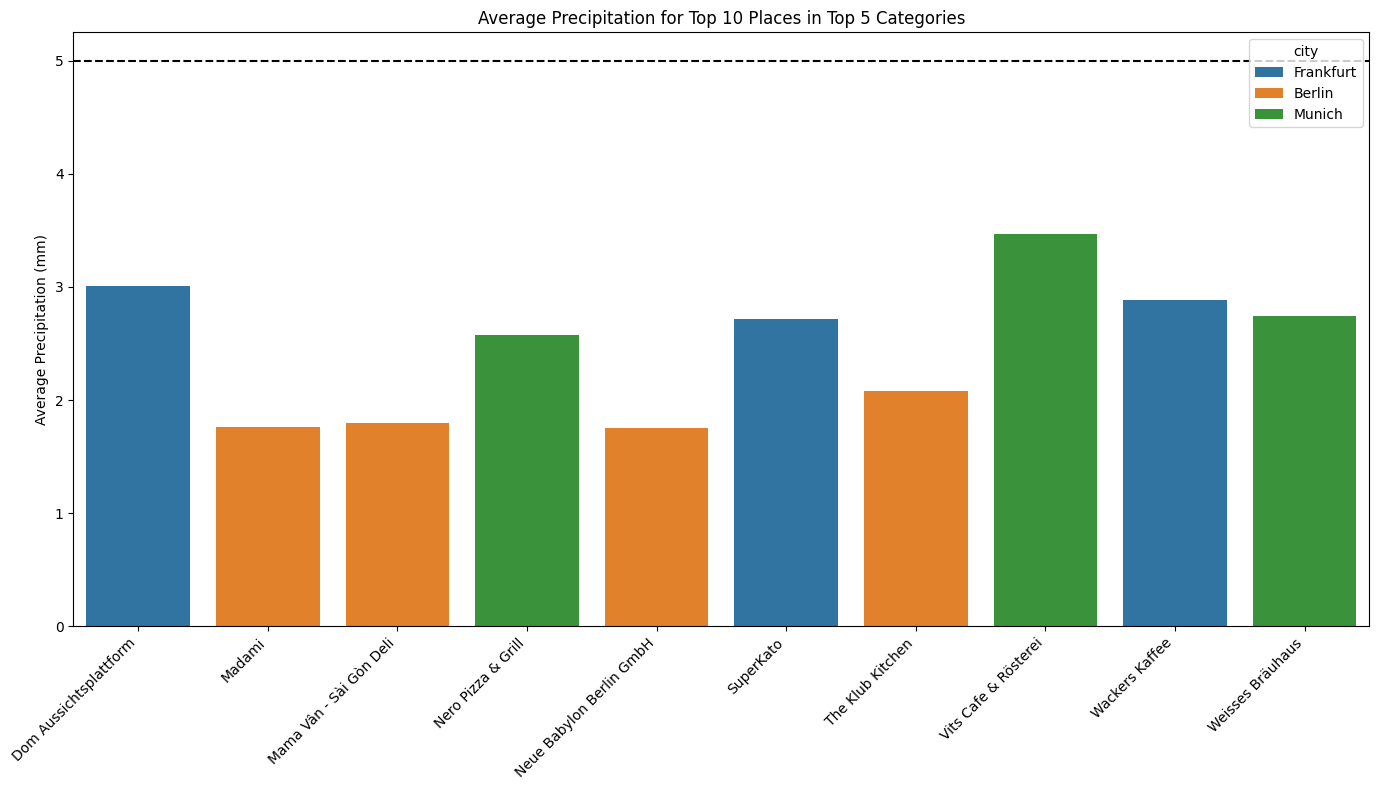

In [14]:
# Plot Average Precipitation for top places
plt.figure(figsize=(14, 8))
sns.barplot(data=avg_wind_precip, x='nearest_place_name', y='avg_precipitation', hue='city')
plt.axhline(y=precipitation_threshold, color='black', linestyle='--')
plt.title('Average Precipitation for Top 10 Places in Top 5 Categories')
plt.xlabel('')
plt.ylabel('Average Precipitation (mm)')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()